## Shared Interaction Network

In this notebook we provide an example of KIN application to the set of MD trajectories and crystal structures. We have previously generated contacts based on each frame of a trunkated MD-trajectory for each prtein structure in the family (simulation_contacts). Here we will convert them into a shared interaction network and obtain an network of interactions that are preserved in the family but are lacking in the protein of choice, missing interaction network. Protein of choice used for both projections is TEM-1 (PDB 1M40). 

In [9]:
import os
from kin.msa_indexing import parse_fasta
from kin.msa_indexing import indexing_pdb_to_msa
from kin.msa_indexing import clean_up_sequence
from kin.msa_indexing import parse_contact_output

 ### **1. Contact indexing according to the MSA alignment**
 
First we need to convert sequence indexing of each protein to the shared indexing based on the multi-sequence alignment(MSA). Steps for MSA with modeller are described in the comparative_data/msa_scores. We will make a set of contacts from crystal structure and 2 sets of contacts from MD a varying MD cutoff (cutoff 10 and cutoff 50). MD cutoff is a measure of how retained certain interaction within the MD trajectory. For further information on selection of the MD cutoff please see the corresponding paper. 

***Crystal structure contact reindexing***

In [10]:
INPUT_DIRECTORY_CS = (
    "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/crystal_contacts"
)
OUTPUT_DIRECTORY_CS = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/static_contacts_processing/msa_index_contacts"

MSA_SEQ_FILE = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/static_contacts_processing/bettaLac.ali"

sequence_dict = parse_fasta(MSA_SEQ_FILE)
# Crystal structure contacts
if os.path.isdir(INPUT_DIRECTORY_CS):
    for filename in os.listdir(INPUT_DIRECTORY_CS):
        if filename.endswith(".txt"):
            file_path = os.path.join(INPUT_DIRECTORY_CS, filename)
            SYSTEM_NAME = filename.split(".txt")[0]
            output_file_path = os.path.join(
                OUTPUT_DIRECTORY_CS, f"{SYSTEM_NAME}_msa_crystal.csv"
            )
            # print("Processing ", SYSTEM_NAME)
            seq, short_seq = clean_up_sequence(sequence_dict, SYSTEM_NAME)
            pdb_df_md = parse_contact_output(
                file_path,
                contact_type="crystal",
            )
            msa_df_md = indexing_pdb_to_msa(seq, pdb_df_md)
            msa_df_md.to_csv(output_file_path, index=False)

***MD-based contact reindexing***

In [11]:
INPUT_DIRECTORY_MD = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/simulation_contacts"
OUTPUT_DIRECTORY_10 = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/msa_index_contacts/retention_10"
OUTPUT_DIRECTORY_50 = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/msa_index_contacts/retention_50"

MSA_SEQ_FILE = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/bettaLac.ali"

sequence_dict = parse_fasta(MSA_SEQ_FILE)
outputs = [OUTPUT_DIRECTORY_10, OUTPUT_DIRECTORY_50]
for output in outputs:
    if not os.path.exists(output):
        os.makedirs(output)
    dirname = output.split("/")[-1]
    cutoff = dirname.split("_")[-1]

    for subdir in os.listdir(INPUT_DIRECTORY_MD):
        subdir_path = os.path.join(INPUT_DIRECTORY_MD, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith(".csv"):
                    file_path = os.path.join(subdir_path, filename)
                    SYSTEM_NAME = filename.split("_all")[0]
                    output_file_path = os.path.join(
                        output, "", f"{SYSTEM_NAME}_msa_md_{cutoff}.csv"
                    )

                    #Convert residue nomenclature from MSA to the MDAnalysis 
                    #format and remove non-standard residues
                    seq, short_seq = clean_up_sequence(sequence_dict, SYSTEM_NAME)
                    
                    #Parse the md contacts and apply desiered cutoff
                    cutoff_value = float(cutoff) / 100
                    pdb_df_md = parse_contact_output(
                        file_path, contact_type="md", retention_percent=cutoff_value
                    )
                    #Index the contacts according to the MSA
                    msa_df_md = indexing_pdb_to_msa(seq, pdb_df_md)
                    
                    #save as csv
                    msa_df_md.to_csv(output_file_path, index=False)



### **2. Form an interaction network for a protein of choice**

Since we want to display the shared interaction network on a structure we need to select a reference structure for the interaction network. It is good to select a protein that, in your opinion, is a good representative of the family or a protein of a particular interest. There are 2 methods implemented to calculate conservation score of a contact: method 1 (**conservation_uniform==True**) disregards whether the ranked contacts are present in the structure of interest and evaluates all contacts based on their abundance in the family; method 2 (**conservation_uniform==False**) does not penalize the contact conservation score if the contact was not able to form due to the absence of the residues in the structure. These methods shown to be quite equivalent in structurally homogeneous families but the second method can be more beneficial for the protein groups with high structural variation. 

Network processing capabilities are analogous for both crystal structure and MD-based data. Here we will focus on the MD based network processing.

In [12]:
import csv
from kin.pymol_projections import project_pymol_res_res_scores
from kin.pymol_projections import project_pymol_per_res_scores
from kin.msa_network import common_network
from kin.msa_network import get_per_res_score
from kin.msa_network import filter_network

To form a shared interaction network we will use common network function. As this operation contains multiple functionalities we will go through input aqnd output variables. 

Generate a network for the TEM-1 protein

**Input variable are:**

        msa_alignment - file of all sequences after MSA alignment 
        input_files - path to the directory with the msa indexed contacts
        network_index - format of the output network
        "1M40_TEM-1" - name of the protein of interest (should be consistent with the name in the MSA alignment file)
        conservation_uniform - chooses between two conservation methods, default is True
        missing_network - if True, the network will be generated for the missing contacts
        no_vdw - if True, the network will be generated without the van der Waals contacts
        (this is the only filtering availabel as a part of network genration bcause number 
        of moderatly conserved vdw interaction can be very large, additional filtering can be applied with filter_network function)

**Output variables are:**

        conservation_tem - dictionary with the conserved interactions and their conservation scores
        colors_int_type - dictionary with the contacts and the pymol-format colors that correspond to the interaction types
        properties - dictionary with the contacts and their properties
        miss_net - dictionary with the preserved interactions that re missing in TEM1 and their conservation scores
        miss_colors - dictionary with the missing interactions and the pymol-format colors that correspond to the interaction types
        miss_prop - dictionary with the missing interactions and their properties

Additionally we can apply a variety of filters to either of the networks.

We can filter the network by the minimum conservation score, interactions type, side chain or main chain contacts  

Interactions can be filtered by any type of the folowwing interaction with following flags: "vdw", "hbond", "saltbridge", "hydrophobic","pipi","cationpi".

Interactions can be filtered based on the location of the interaction residues with the following flages where "sc" stands for side chain and "mc" stands for main chain: "sc-sc", "mc-mc", "mc-sc", "sc-mc"

We can also filter by minimum conservation score, for example if min_score=0.5, saved interactions will be conserved preserved in at least 50% of the structures

***MD-based conserved interaction ntwork***

In [13]:
input_fiels_10 = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/msa_index_contacts/retention_10"
input_fiels_50 = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/msa_index_contacts/retention_50"
msa_alignment = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/bettaLac.ali"
# Format for the output interaction network can be specifed as a pdb indexing of the protein of choice of as a msa indexing
network_index = "pdb"
input_files_list = [
    input_fiels_10,
    input_fiels_50,
]
for input_files in input_files_list:
    # Make a shared interaction network
    (
        conservation_tem,
        colors_int_type,
        properties,
        miss_net,
        miss_colors,
        miss_prop,
    ) = common_network(
        msa_alignment,
        input_files,
        "1M40_TEM-1",
        network_index,
        conservation_uniform=True,
        missing_network=True,
        no_vdw=True,
    )
    retention = input_files.split("/")[-1]
    retention_number = retention.split("_")[-1]
    # Apply filters to get interaction network of hydrophobic interactions
    # preserved in at least 50% of structures that
    # occure between not main chain-main chain residues

    new_network, new_colors, new_properties = filter_network(
        conservation_tem,
        colors_int_type,
        properties,
        min_score=0.5,
        network_index="pdb",
        loc_exclude=["mc-mc"],
        int_exclude=["hbond", "saltbridge", "pipi", "cationpi"],
    )

    # Output a pymol visualization of the conserved interactions network

    network_csv = (
        f"dynamic_contacts_processing/shared_network/MD_TEM1_{retention_number}.csv"
    )
    filtered_network_csv = f"dynamic_contacts_processing/shared_network/MD_TEM1_hydrophobic_no_mc-mc_{retention_number}.csv"
    projection_output = f"dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_{retention_number}.pml"
    # visualize as a res-res interactions
    if new_network is not None:
        project_pymol_res_res_scores(new_network, projection_output, new_colors)

        with open(network_csv, "w", newline="") as csvfile:
            csv_writer = csv.DictWriter(csvfile, fieldnames=conservation_tem.keys())
            csv_writer.writeheader()
            csv_writer.writerow(conservation_tem)

        with open(filtered_network_csv, "w", newline="") as csvfile:
            csv_writer = csv.DictWriter(csvfile, fieldnames=new_network.keys() )
            csv_writer.writeheader()
            csv_writer.writerow(new_network)
            
    # caluclate and visualize per residue scores
    per_res_score = get_per_res_score(new_network)
    project_pymol_per_res_scores(
        per_res_score,
        f"dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_{retention_number}.pml",
    )
    properties_filename = f"dynamic_contacts_processing/shared_network/properties_hydrophobic_no_mc-mc_{retention_number}.csv"
    properties.to_csv(properties_filename, index=False)

    # Output a pymol visualization of the missing interactions network
    miss_projection = f"dynamic_contacts_processing/missing_network/tem1_missing_nvdw_{retention_number}.pml"

Target structure is: 1M40_TEM-1
Function: conservation_nextwork_dict
Elapsed time: 0.011694 seconds
Number of missing contacts: 1895
The file: dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_10.pml was written to disk.
The file: dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_10.pml was written to disk.
Target structure is: 1M40_TEM-1
Function: conservation_nextwork_dict
Elapsed time: 0.010819 seconds
Number of missing contacts: 1142
The file: dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_50.pml was written to disk.
The file: dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc_50.pml was written to disk.


***Crystal structure-based conserved interaction network***

In [14]:
input_file_cs = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/static_contacts_processing/msa_index_contacts"
msa_alignment = "/Users/dariiayehorova/lk_research/tools-project/contact_analysis/dynamic_contacts_processing/bettaLac.ali"
# Format for the output interaction network can be specifed as a pdb indexing of the protein of choice of as a msa indexing
network_index = "pdb"
(
    conservation_tem,
    colors_int_type,
    properties,
    miss_net,
    miss_colors,
    miss_prop,
) = common_network(
    msa_alignment,
    input_files,
    "1M40_TEM-1",
    network_index,
    conservation_uniform=True,
    missing_network=True,
    no_vdw=True,
)

new_network, new_colors, new_properties = filter_network(
    conservation_tem,
    colors_int_type,
    properties,
    min_score=0.5,
    network_index="pdb",
    loc_exclude=["mc-mc"],
    int_exclude=["hbond", "saltbridge", "pipi", "cationpi"],
)

# Output a pymol visualization of the conserved interactions network
filtered_network_csv = "static_contacts_processing/shared_network/CS_TEM1_hydrophobic_no_mc-mc.csv"
network_csv = "static_contacts_processing/shared_network/CS_TEM1.csv"
projection_output = "static_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc.pml"

if new_network is not None:
    project_pymol_res_res_scores(new_network, projection_output, new_colors)
    
    with open(filtered_network_csv, "w", newline="") as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=new_network.keys())
        csv_writer.writeheader()
        csv_writer.writerow(new_network)
    
    with open(network_csv, "w", newline="") as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=conservation_tem.keys())
        csv_writer.writeheader()
        csv_writer.writerow(conservation_tem)
    

# caluclate and visualize per residue scores
per_res_score = get_per_res_score(new_network)
project_pymol_per_res_scores(
    per_res_score,
    "dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc.pml",
)
properties_filename = "dynamic_contacts_processing/shared_network/properties_hydrophobic_no_mc-mc.csv"
properties.to_csv(properties_filename, index=False)



Target structure is: 1M40_TEM-1
Function: conservation_nextwork_dict
Elapsed time: 0.011295 seconds
Number of missing contacts: 1142
The file: static_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc.pml was written to disk.
The file: dynamic_contacts_processing/shared_network/TEM1_hydrophobic_no_mc-mc.pml was written to disk.


### 3. Comparison of MD and crystal structure conserved interaction networks

In this sections we will compare shared interaction networks using nstructing contact maps and histograms. Contact maps are a usefull visualization format because they highlight what secondary structure motives are preseved within these interaciton networks. [Here](ttps://en.wikipedia.org/wiki/Protein_contact_map) is a quick guide to interpretation of the contact map motives.  

In [15]:
from kin.msa_network import make_grid
from kin.msa_network import plot_int_map
from kin.msa_network import get_contacts_from_csv
from kin.msa_network import plot_hist_of_contacts
from scipy.stats import pearsonr


_______________________________
MD_TEM1_10
_______________________________
Pearson correlation coefficient between crystal structure net and  MD_TEM1_10
PearsonRResult(statistic=0.8679338024168914, pvalue=0.0)


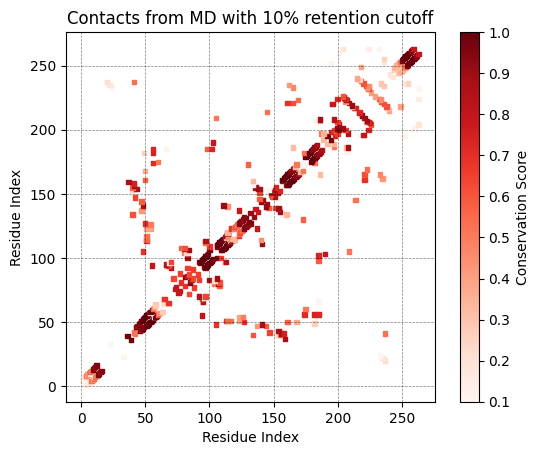

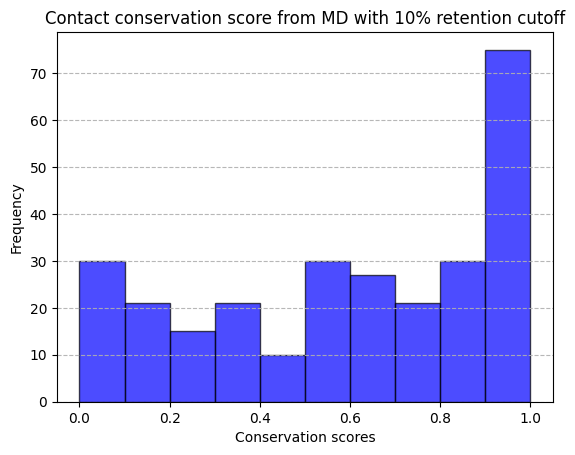

_______________________________
MD_TEM1_50
_______________________________
Pearson correlation coefficient between crystal structure net and  MD_TEM1_50
PearsonRResult(statistic=1.0, pvalue=0.0)


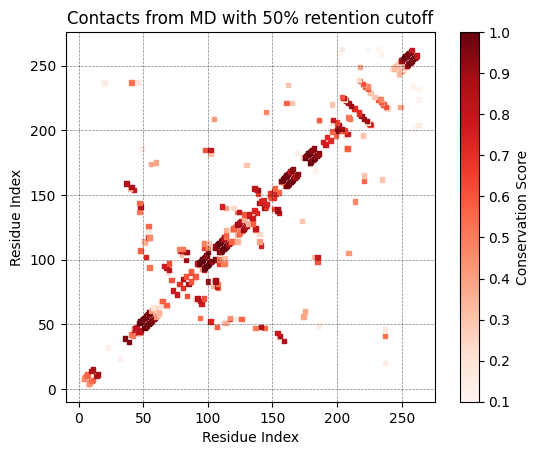

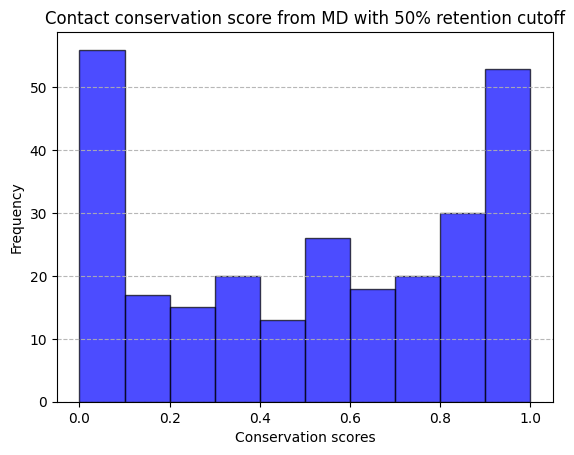

_______________________________
MD_TEM1_hydrophobic_no_mc-mc_10
_______________________________
Pearson correlation coefficient between crystal structure net and  MD_TEM1_hydrophobic_no_mc-mc_10
PearsonRResult(statistic=0.3923003467846059, pvalue=0.0)


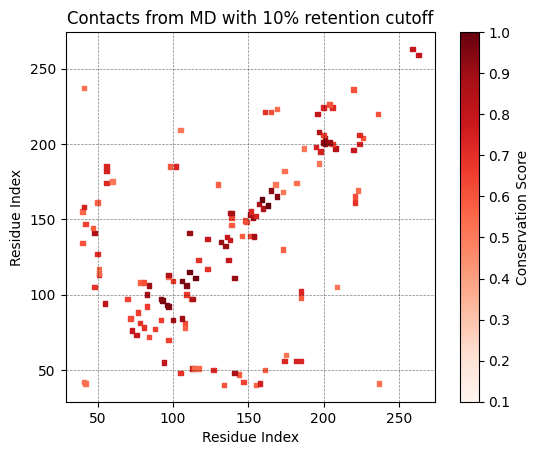

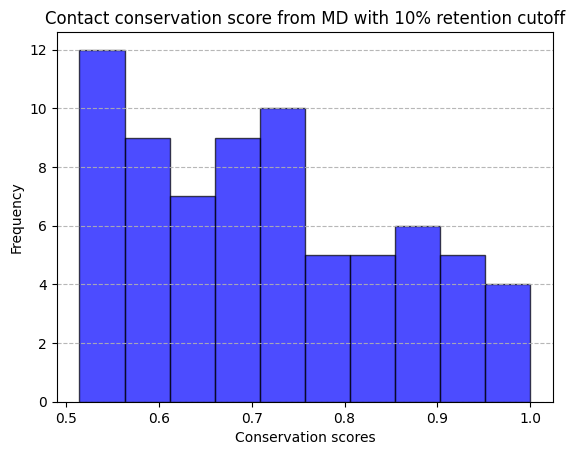

_______________________________
MD_TEM1_hydrophobic_no_mc-mc_50
_______________________________
Pearson correlation coefficient between crystal structure net and  MD_TEM1_hydrophobic_no_mc-mc_50
PearsonRResult(statistic=0.5208455516899362, pvalue=0.0)


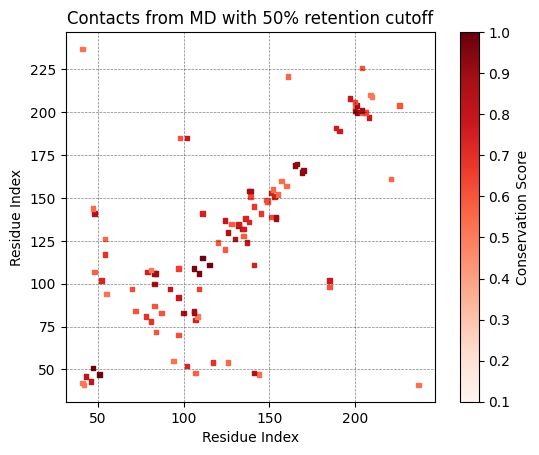

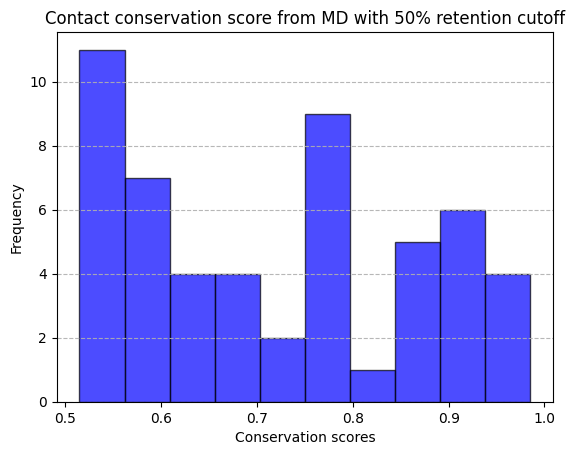

_______________________________
CS_TEM1
_______________________________
Pearson correlation coefficient between crystal structure net and  CS_TEM1
PearsonRResult(statistic=1.0, pvalue=0.0)


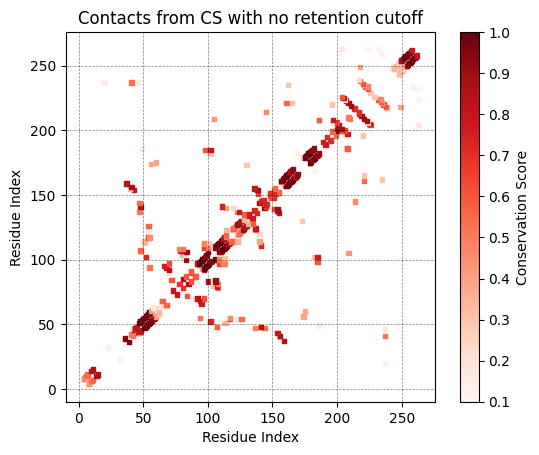

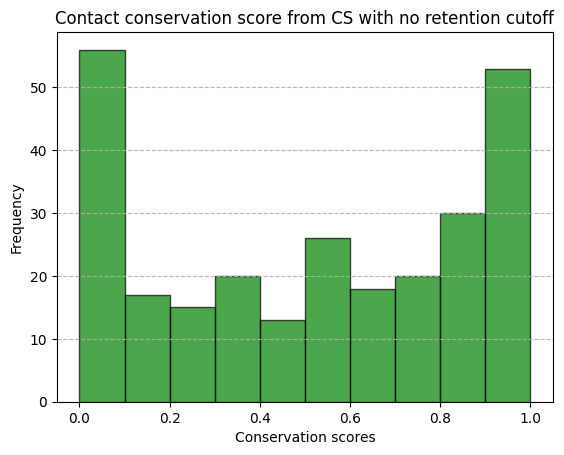

_______________________________
CS_TEM1_hydrophobic_no_mc-mc
_______________________________
Pearson correlation coefficient between crystal structure net and  CS_TEM1_hydrophobic_no_mc-mc
PearsonRResult(statistic=0.5208455516899362, pvalue=0.0)


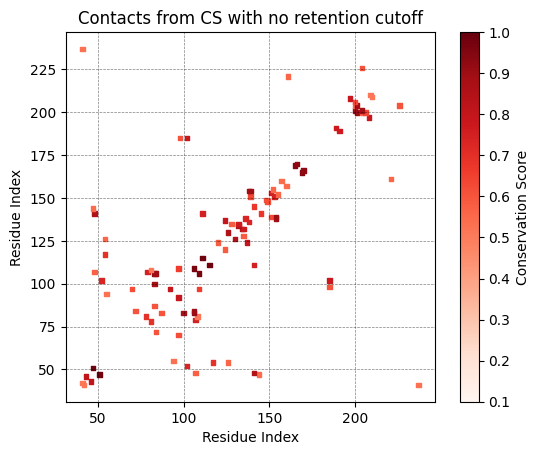

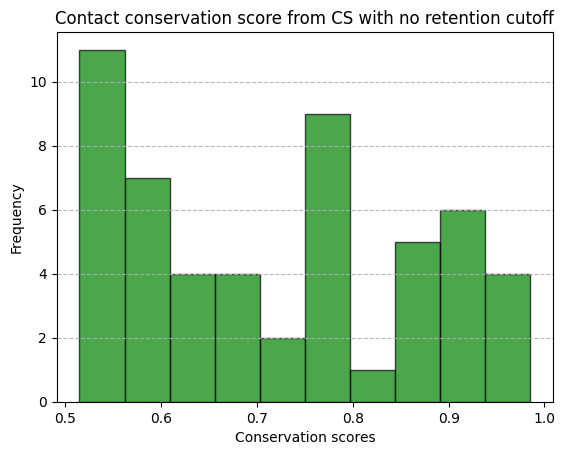

In [16]:
# Path to the shared interaction networks prior to filtering
crystal_full = "static_contacts_processing/shared_network/CS_TEM1.csv"
md_full_10 = "dynamic_contacts_processing/shared_network/MD_TEM1_10.csv"
md_full_50 = "dynamic_contacts_processing/shared_network/MD_TEM1_50.csv"

# Path to the shared interaction networks after filtering out interactions that are not hydrophobic or are between main chain residues
crystal_reduced = (
    "static_contacts_processing/shared_network/CS_TEM1_hydrophobic_no_mc-mc.csv"
)
md_reduced_10 = (
    "dynamic_contacts_processing/shared_network/MD_TEM1_hydrophobic_no_mc-mc_10.csv"
)
md_reduced_50 = (
    "dynamic_contacts_processing/shared_network/MD_TEM1_hydrophobic_no_mc-mc_50.csv"
)

# Number of residues in the protein that the network was projected onto (TEM-1)
TOTAL_RES_NUMBER = 263

networks_crystal = [crystal_full, crystal_reduced]
networks_md = [md_full_10, md_full_50, md_reduced_10, md_reduced_50]
networks_files = [
    md_full_10,
    md_full_50,
    md_reduced_10,
    md_reduced_50,
    crystal_full,
    crystal_reduced,
]
crystal_full_net = get_contacts_from_csv(crystal_full)
crystal_grid = make_grid(crystal_full_net, TOTAL_RES_NUMBER)

for net_file in networks_files:
    net = get_contacts_from_csv(net_file)
    net_name = net_file.split("/")[-1]
    net_name = net_name.split(".csv")[0]
    net_type = net_name.split("_")[0]
    if net_type == "MD":
        retention_cutoff = net_name.split("_")[-1] + "%"
        color_choice = "blue"
    else:
        retention_cutoff = "no"
        color_choice = "green"
    grid = make_grid(net, TOTAL_RES_NUMBER)
    print("_______________________________")
    print(net_name)
    print("_______________________________")
    print("Pearson correlation coefficient between crystal structure net and ", net_name)
    print(pearsonr(crystal_grid.flatten(), grid.flatten()))
    plot_int_map(
        grid, f"Contacts from {net_type} with {retention_cutoff} retention cutoff"
    )
    plot_hist_of_contacts(
        net,
        f"Contact conservation score from {net_type} with {retention_cutoff} retention cutoff",
        color_choice,
    )